In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# --- 1. Preprocessing and Transforms ---
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.01)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [10]:
def ProjectDataLoader(path='./digits', transform=None):
    images, labels = [], []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            label = int(filename.split('-')[0])
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L').resize((28, 28))
            if transform:
                img = transform(img)
            else:
                img = transforms.ToTensor()(img)
            images.append(img)
            labels.append(label)
    return torch.stack(images), torch.tensor(labels).long().squeeze()

custom_batch, custom_labels_tensor = ProjectDataLoader('./digits', transform=transform_train)
custom_dataset = TensorDataset(custom_batch, custom_labels_tensor)
trainloader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

# --- 3. Load MNIST for Testing Only ---
testset = datasets.MNIST('MNIST_data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [11]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),  # 512 neurons
    nn.ReLU(),
    nn.Linear(512, 256),    # 256 neurons
    nn.ReLU(),
    nn.Linear(256, 64),     # 64 neurons
    nn.ReLU(),
    nn.Linear(64, 10)       # Output layer
)


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = []  # <-- Add this before training loop

for epoch in range(50):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    loss_history.append(epoch_loss)  # <-- Save loss
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")



Epoch 1 Loss: 2.3235
Epoch 2 Loss: 2.3117
Epoch 3 Loss: 2.3057
Epoch 4 Loss: 2.2892
Epoch 5 Loss: 2.3033
Epoch 6 Loss: 2.2696
Epoch 7 Loss: 2.2255
Epoch 8 Loss: 2.1596
Epoch 9 Loss: 2.0746
Epoch 10 Loss: 1.9808
Epoch 11 Loss: 1.9031
Epoch 12 Loss: 1.8608
Epoch 13 Loss: 1.7119
Epoch 14 Loss: 1.6961
Epoch 15 Loss: 1.5853
Epoch 16 Loss: 1.4830
Epoch 17 Loss: 1.5142
Epoch 18 Loss: 1.5099
Epoch 19 Loss: 1.5494
Epoch 20 Loss: 1.5104
Epoch 21 Loss: 1.4833
Epoch 22 Loss: 1.3449
Epoch 23 Loss: 1.2420
Epoch 24 Loss: 1.2472
Epoch 25 Loss: 1.2457
Epoch 26 Loss: 1.1755
Epoch 27 Loss: 1.2186
Epoch 28 Loss: 1.1097
Epoch 29 Loss: 1.0637
Epoch 30 Loss: 1.0702
Epoch 31 Loss: 1.0308
Epoch 32 Loss: 1.0012
Epoch 33 Loss: 1.0021
Epoch 34 Loss: 1.0146
Epoch 35 Loss: 1.2888
Epoch 36 Loss: 1.0778
Epoch 37 Loss: 0.9573
Epoch 38 Loss: 1.0169
Epoch 39 Loss: 0.9405
Epoch 40 Loss: 0.9241
Epoch 41 Loss: 1.0379
Epoch 42 Loss: 0.8481
Epoch 43 Loss: 0.9877
Epoch 44 Loss: 0.8709
Epoch 45 Loss: 0.7968
Epoch 46 Loss: 0.84

In [13]:
# --- 7. Testing on MNIST Test Set ---
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nAccuracy on MNIST test set: {100 * correct / total:.2f}%")


Accuracy on MNIST test set: 42.38%


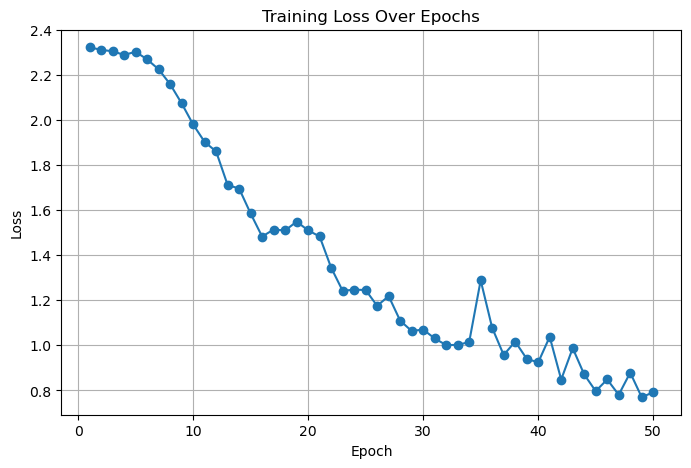

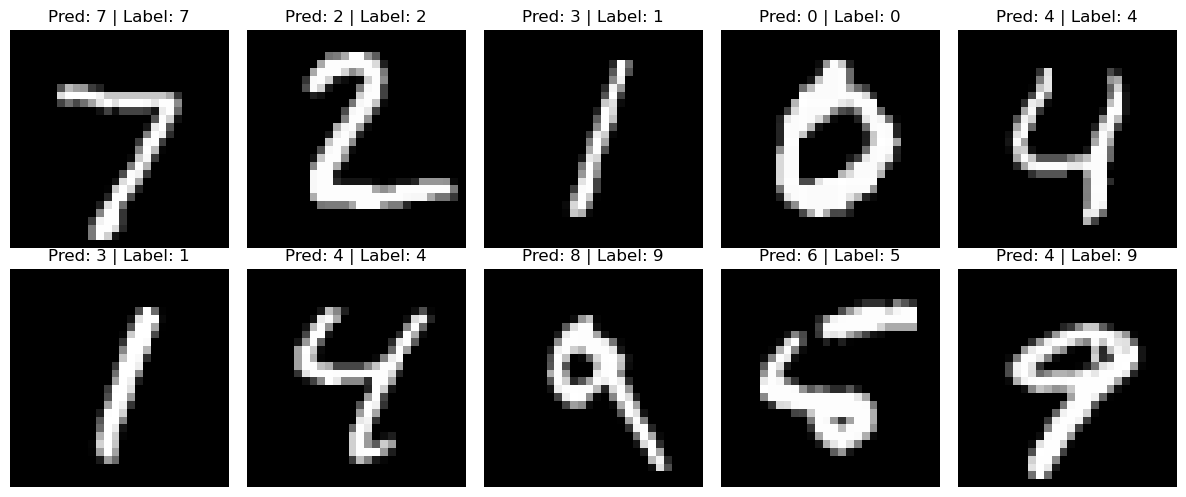

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# --- 8. (Optional) Visualize a Few Test Predictions ---
def show_mnist_predictions(model, testloader):
    model.eval()
    images, labels = next(iter(testloader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f"Pred: {preds[i].item()} | Label: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_mnist_predictions(model, testloader)